In [1]:
using Random, Distributions, Plots, Statistics

# Homework 2


## Mc-Call Job Search Model with Separation 

We consider here a very simple job-search model, with separation. Our goal consists in solving this model using a policy iteration algorithm. Some background on the McCall and numerical ideas are discussed on the [QuantEcon](`https://julia.quantecon.org/mccall_model.html`) website.

There is a single worker who can be either employed ("e") or unemployed ("u") in any period.

When unemployed, the jobless worker receives unemployment benefits $c_t=\alpha>0$ in every period as long as he stays unemployed. He also receives a salary offer $w_t$ which is drawn from a discrete i.i.d. distribution and takes values $w_1, ..., w_K$ with probabilities $p_1, ... p_K$ respectively.

When an unemployed worker accepts an offer in period $t$, he gets the salary $w_t$ and becomes employed. He then keeps his salary $w_t$ as long as he stays employed (for $s\geq t$, $c_s=w_t$ if $t$ is the date at which worker got the current job); in each period he has a probability $\lambda$ of becoming unemployed in the next period and remains employed otherwise.

When a worker receives a given amount $x$ his perceived utility is $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma>1.0$. A worker discounts the future at a rate $\beta \in [0,1[$. As a result, in any period $t_0$ workers seek to maximize $\sum_{t\geq t_0}^{\infty} U(c_t)$.


__Define a parameter type `Parameter`, with fields $\alpha$, $\beta$, $\gamma$, $K$, $\sigma$, $\lambda$. Create a parameter variable $\omega$ with $\alpha=0.5$, $\beta=0.96$, $\gamma=4$, $K=10$, $\sigma=0.6$, $\lambda=0.015$__

In [2]:
struct Parameter
    α
    β
    γ
    K
    σ
    λ
end

ω = Parameter(0.5, 0.96, 4, 10, 0.6, 0.015)
η = 1e-10;

__What is the uniform distribution, whose mean is 1 and standard deviation is $\sigma$? Write a function `discrete_uniform(σ::Float64, K::Int64)::Tuple{Vector{Float64} Vector{Float64}}` to discretize it, using $K$ points. The function should return two vectors `w` and `p` of floats of the same size `K`. Check the results satisfy the right conditions (uniformity, standard deviation).__

A uniform distribution with a mean of 1 is a distribution taking values between $1-e$ and $1+e$ with $e \in \mathbb{R}^+$ to be determined.

we know that the formula for X a random variable with a uniform distribution is the following:

$$
Var[X] = \frac{(b-a+1)^2-1}{12}
$$

Thus by the following computations, we can determine the e we need to have a distribution with standard deviation $\sigma$

\begin{align}
\sigma^2 &= \frac{(1+e - (1-e) + 1)^2 -1}{12} \\
\sigma^2 &= \frac{(2e + 1)^2 - 1}{12} \\
\sigma^2 &= \frac{4e^2+4e}{12} \\
\sigma^2 &= \frac{e^2+e}{3}\\
 0 &= e^2+e - 3\sigma^2
\end{align}

thus we can conclude the solution of e is $\frac{- 1 - \sqrt{1+12\sigma^2}}{2}, \frac{- 1 + \sqrt{1+12\sigma^2}}{2} $.  because we chose e to be positive, we have $e=\frac{- 1 + \sqrt{1+12\sigma^2}}{2}$ for a given $\sigma$.

In [3]:
function compute_p(K::Int64)
    return repeat([1/K]; outer=[K])
end

function compute_w(μ::Float64, σ::Float64, K::Int64)
    e = (-1+sqrt(1+12*σ^2))/2
    return [μ-e+(2e*i/(K-1)) for i=0:K-1]
end

function discrete_uniform(σ::Float64, K::Int64; μ=1.0)
    return compute_w(μ, σ, K), compute_p(K)
end


discrete_uniform (generic function with 1 method)

In [4]:
w, p = discrete_uniform(ω.σ, ω.K)
std = sqrt(((w[length(w)] - w[1] + 1)^2 - 1) / 12)
m = sum(w.*p)
println("the standard deviation is: $std")
println("the mean is: $m")

the standard deviation is: 0.6000000000000001
the mean is: 1.0


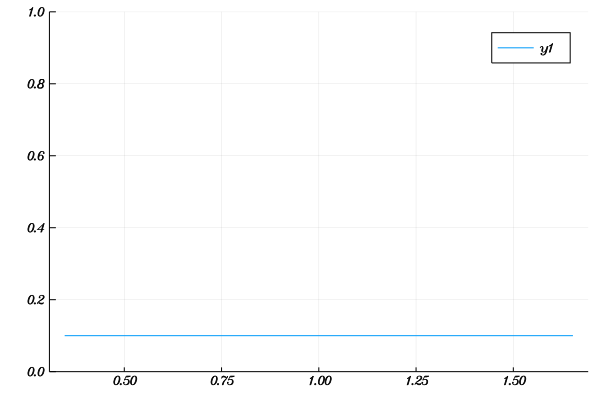

In [5]:
plot(w, p, ylims=(0,1))


The optimal decision of a worker is characterized by two value functions: $V^E(w)$ is the value of being employed at wage $w$ and $V^U(w)$ the value of being unemployed, while receiving job offer $w_t$. In Julia, both $V^U$ and $V^E$ will be represented by arrays `V_U` and `V_E` of size `K`.

A policy `g(w)` is a binary choice in the unemployed state: accept or reject an offer $w_t$. It will then naturally be represented by a boolean array (type `zeros(Bool, K)` to initialize one).

__Given a policy $g$, write down the recursive equations which defines the corresponding value functions $V^{U,g}(w)$ and $V^{E,g}(w)$.__

we denote $\mathbb{w}$ to be the set of possible wages and their corresponding probability to be $\mathbb{p}$

for $V^{E, g}(w)$, the recursive equation should be expressed by the current reward $w$, and the discounted expected reward tomorrow with probability of being fired:

$$
V^{E, g}(w) = U(w) + \beta[(1-\lambda)V^{E, g}(w) + \lambda E[V^{U, g}(w)]]
$$


for $V^{U, g}(w)$ we have that the agent maximizes between her options (to accept or to reject). If she accepts, then the value is equal to $V^{E, g}(w)$, if she rejects, the value will be the compensation $\alpha$ and the discounted value of unemployment tomorrow. thus, with $g$ given, we will have following recursive equations:
$$ 
V^{U, g}(w) = \begin{cases}
U(\alpha) +  E[V^{U, g}(w)] \text{ if g(w) is 0}\\
U(w) + \beta V^{E, g}(w) \text{ if g(w) is 1}
\end{cases}
$$


To assist our functions, we will try to find the "reservation wage" which will act as a threshold of when our agent should make her decision upon. 

We will note that $E[V^{U, g}(w)] = \sum_{i=1}^K p_iV^U(w_i)$ be the expected value of unemployment tomorrow. 
Assuming our agent behaves rationally, we see that our agent will accept the offer if $V^{E, g}(w) \geq U(\alpha) +  \beta E[V^{U, g}(w)]$. Thus, our reservation wage $\bar{w}$ needs to solve:
$$
V^{E, g}(\bar{w}) = U(\alpha) +  \beta E[V^{U, g}(\bar{w})]
$$


__Write a function which takes a guess $V^{U,g}(w)$ and $V^{E,g}(w)$ and a policy function $g$ as arguments (and other model parameters) and updates the values, according to the updating equations. This function could have signature `value_update(V_U::Vector{Float64}, V_E::Vector{Float64}, g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64})::Tuple{Vector{Float64}, Vector{Float64}}` where the returned vector has the same size as the supplied ones.__

In [6]:
function U(x::Float64; γ = ω.γ)
    return (x^(1-γ))/(1-γ)
end

function expected_V_U(w::Vector{Float64}, p::Vector{Float64})
    return sum(U.(w).*p)
end

function value_update(V_U::Vector{Float64}, V_E::Vector{Float64},
    g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64})
    new_V_U, new_V_E = zeros(ω.K), zeros(ω.K)
    for (i, accept) in enumerate(g)
        if accept
            new_V_U[i] = U(w[i]) + ω.β * V_E[i]
        else
            new_V_U[i] = U(w[i]) + ω.β * expected_V_U(w, p)
        end
    end
    for i=1:ω.K
        new_V_E[i] = U(w[i]) + ω.β * ω.λ *V_E[i] +  ω.β * (1 - ω.λ) * expected_V_U(w, p)
    end
    return new_V_U, new_V_E
end

value_update (generic function with 1 method)


__Write a function `eval_policy(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Tuple{Vector{Float64}, Vector{Float64}}` which iterates on `value_update` find the values that satisfy the evaluation equations for policy `g`.__


In [7]:
function eval_policy(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64; T=1000)
    V_U_0, V_E_0 = zeros(ω.K), zeros(ω.K)
    V_U, V_E = zeros(ω.K), zeros(ω.K)
    i = 0
    for _=1:T
        i += 1
        V_U, V_E = value_update(V_U_0, V_E_0, g, ω, w, p)
        err = sum((V_U .- V_U_0)) + sum((V_E .- V_E_0))
        if err < η
           break 
        end
        V_U_0, V_E_0 = V_U, V_E
    end
    return V_U, V_E
end



eval_policy (generic function with 1 method)


__Write a function `improve_policy(g::Vector{Bool}, V_U::Vector{Bool}, V_E::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Vector{Float64}` which returns the improved policy given guesses for the value function(s) at for $t+1$.__

In [8]:
function get_value(g, V_U, V_E)
    val = 0
    for i=1:length(g)
        if g[i]
            val += V_E[i]
        else
            val += V_U[i]
        end
    end
    return val
end

function improve_policy(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64, max_value)
    # then record which one that creates the most difference
    new_g = g
    V_U = 0
    V_E = 0
    new_value = 0
    for i=1:100
        dum_g = rand(Bool, ω.K)
        V_U, V_E = eval_policy(dum_g, ω, w, p, η)
        new_value = get_value(dum_g, V_U, V_E)
        if new_value > max_value
            println("new ones received")
            max_value = new_value
            new_g = dum_g
        end
    end
    return new_g, V_U, V_E, new_value
end

improve_policy (generic function with 1 method)

__Implement the policy function algorithm. Print the successive approximation errors and comment on the convergence speed.__

In [9]:
function policy_function_algo(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64; T = 10)
    error, value = Vector{Float64}(), Vector{Float64}()
    V_U_0, V_E_0 = eval_policy(g, ω, w, p, η)
    new_g = rand(Bool, ω.K)
    for _=1:T
        println("old" , new_g)
        current_value = get_value(new_g, V_U_0, V_E_0)
        new_g, V_U_0, V_E_0, new_value = improve_policy(g, ω, w, p, η, current_value)
        println("new", new_g)
        err = new_value - current_value
        push!(error, err)
        push!(value, new_value)
        if 0 < err < η
            break
        end
        
    end
    return new_g, error, value
end


policy_function_algo (generic function with 1 method)

In [10]:
g = rand(Bool, ω.K)
new_g, err, value = policy_function_algo(g, ω, w, p, η)

oldBool[0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
oldBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
oldBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
oldBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
oldBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
oldBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
oldBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
oldBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
oldBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
oldBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
newBool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]


(Bool[1, 0, 0, 0, 1, 0, 0, 0, 0, 1], [-2.679695407327465, -2.599304545107632, -6.699238518318662, -2.679695407327465, -2.6595976917725004, -5.319195383545011, -5.218706805770225, -9.29854306342629, -5.319195383545011, -3.959249964326318], [-27.274833087581342, -27.214539940916467, -27.2949308031363, -27.294930803136296, -27.274833087581335, -27.25473537202638, -27.1542467942516, -27.21453994091647, -27.25473537202638, -27.234637656471424])

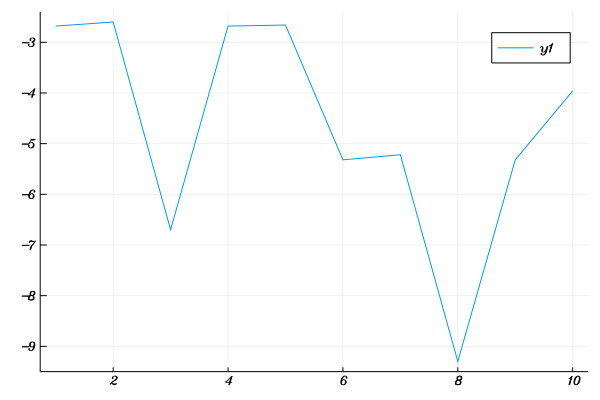

In [11]:
plot(err)

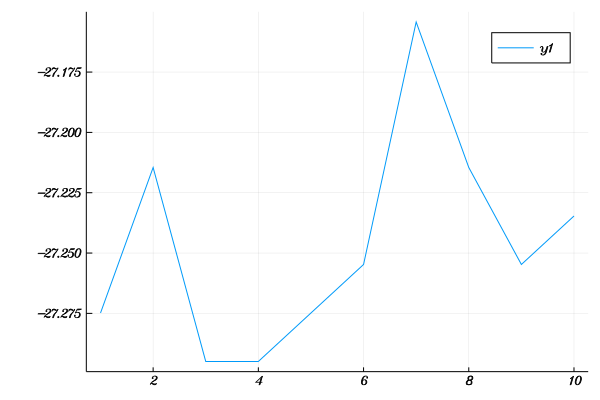

In [12]:
plot(value)


## Neoclassical growth model (2)

We consider here, another deterministic version of the neoclassical growth model, but propose a slightly different solution method.

A representative agent uses capital $k_t$ to produce $y_t$ using the following production function:

$$y_t = k_t^{\alpha}$$

He chooses to consume an amount $c_t \in ]0, y_t]$ and invests what remains:

$$i_t = y_t - c_t$$.

He accumulates capital $k_t$ according to:

$$k_{t+1} = \left( 1-\delta \right) k_{t} + i_{t}$$

where $\delta$ is the depreciation rate and $i_t$ is the amount invested.

The goal of the representative agent is to maximize:

$$\sum_{t\geq 0} \beta^t U(c_t)$$

where $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ and $\beta<1$ is the discount factor.

Since the problem is time homogenous, the value function depends on available capital only and satisfies the following Bellman equation:

$$V\left(\underbrace{k}_{k_t}\right) = \max_{c\in[0,1[} U(c) + \beta V\left(\underbrace{(1-\delta)k + \underbrace{(k^{\alpha}-c)}_{y_{t+1}}}_{k_{t+1}}\right)$$

Our goal is to obtain a smooth approximation of $k$ and $V$ by using interpolations techniques.

For this model, using the dynamic first-order conditions, one can show the deterministic steady-state of the model satisfies $1=\beta \left( (1-\delta) + \alpha k^{\alpha -1} \right)$. 

__Create a suitable Parameter type to hold the parameters. Write a function `steady_state(p::Parameter)` to compute the steady-state capital `kbar` and the corresponding steady-state consumption `cbar`__ 


In [15]:
struct Parameter
    α
    β
    γ
    δ
end


ErrorException: invalid redefinition of constant Parameter

In [67]:
# similar with borkman 7 discrete markov
# difference is in the exer, the value tomorrow is restricted to be in a grid with finite number of states, 
# now we interpolate, so choose the consumption the use non linear solver to find the optimal
# only change is how you deal with capital tomorrow

function U(x, p::Parameter)
    return (x ^ (1-p.γ))/(1-p.γ)
end

In [ ]:
function steady_state(p::Parameter)
    # to do
end

__Set $N=10$ and define a reasonable grid `kgrid=range(kmin, kmax; length=N)` to approximate capital $k$.__


__The unknown value function is represented as a `N` elements arrays. Define `Vi(k,p)=U(δ * k^α)/(1-𝛽)` and compute the initial guess `V0 = [Vi(k,p) for k in kgrid]`. Define a finer grid `ktest=range(kmin, kmax;length=1000)` and find the values of `Vi` on it by  using `Interpolations.jl` library to interpolate `V0` between the points of `kgrid`.__



__Compute a Bellman improvement function `bellman(V0::Vector{Float64}, p::Parameter, kgrid)::Tuple{Vector{Float64}, Vector{Float64}}` which does the following steps:__

- take an initial guess `V0` for the value function

- at each grid point from kvec, optimize nonlinearly, the function $c \rightarrow U(c) + \beta V\left((1-\delta)k + (k^{\alpha}-c)\right)$ for each capital level in the grid `kvec`. In this expression the function `V()` interpolates `V0` defined on `kvec` on any point `k` so that the resulting function is continuous. 

- return the updated value and investment rules


__Write a value interation function `vfi(N, p)` which solves the model defined by parameter `p` using the value function algorithm. The function should return the value function and the policy rule.__


__Plot the solution. Comment.__

__Bonus 1: plot a graph showing the convergence back to the steady-state__


__Bonus 2: implement the policy iteration algorithm by adding an evaluation step in the `vfi` function.__
